In [1]:
# --- Imports ---
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.stats import entropy
import sys
import traceback
from hashlib import sha256
import random

%matplotlib inline

In [3]:
class LogisticMap1D:
    """A simple 1D Logistic Map for analysis."""
    def __init__(self, r, x0):
        self.r = r
        self.x = x0
    
    def _step(self):
        self.x = self.r * self.x * (1 - self.x)
        return self.x

    def generate_sequence(self, size, transient=1000):
        """Generates a chaotic sequence of a given size."""
        # Run map to settle into the attractor
        for _ in range(transient):
            self._step()
        
        sequence = np.zeros(size)
        for i in range(size):
            sequence[i] = self._step()
        return sequence

def analyze_1D_logistic():
    """Performs Bifurcation and Lyapunov analysis for the 1D Logistic Map."""
    print("--- 1. Analyzing 1D Logistic Map ---")
    
    print("Generating 1D Bifurcation Diagram...")
    r_range = np.linspace(2.5, 4.0, 1000)
    samples = 200
    bifurcation_data = np.zeros((1000, samples))

    for i, r in enumerate(r_range):
        map_1d = LogisticMap1D(r, 0.2)
        for _ in range(1000): map_1d._step() # Settle
        for j in range(samples):
            bifurcation_data[i, j] = map_1d._step()
            
    plt.figure(figsize=(10, 6))
    plt.plot(r_range, bifurcation_data, ',k', alpha=0.1)
    plt.xlabel("Parameter 'r'")
    plt.ylabel("System State 'x'")
    plt.title("Bifurcation Diagram of 1D Logistic Map")
    plt.savefig("bifurcation_1d_logistic.png")
    plt.show()
    plt.close()
    
    print("Calculating 1D Lyapunov Exponent...")
    r = 4.0 
    steps = 10000
    map_1d = LogisticMap1D(r, 0.2)
    for _ in range(1000): map_1d._step() # Settle
    
    lle_sum = 0.0
    for _ in range(steps):
        x = map_1d._step()
        # f'(x) = r*(1 - 2*x)
        derivative = r * (1 - 2 * x)
        if abs(derivative) > 1e-10: # Avoid log(0)
            lle_sum += np.log(abs(derivative))
            
    lle = lle_sum / steps
    print(f"LLE for 1D Logistic Map (r=4.0): {lle:.4f} (Ideal is ln(2) ~ 0.693)")
    print("----------------------------------------\n")

In [5]:
class Coupled3DMap:
    """A 3D Coupled Map, based on the 'mod 10' handwritten notes."""
    def __init__(self, x0, y0, z0, params):
        self.x, self.y, self.z = x0, y0, z0
        self.r0 = params["r0"]
        self.k1 = params["k1"]
        self.c0 = params["c0"]
        self.k2 = params["k2"]

    def _step(self):
        r_x = self.r0 + self.k1 * (self.y * self.z) % 10.0
        r_y = self.r0 + self.k1 * (self.x * self.z) % 10.0
        r_z = self.r0 + self.k1 * (self.x * self.y) % 10.0
        C_n = self.c0 + self.k2 * (self.x + self.y + self.z)
        
        x_old, y_old, z_old = self.x, self.y, self.z
        
        self.x = (r_x * x_old * (1 - x_old) + C_n * (y_old + z_old)) % 1.0
        self.y = (r_y * y_old * (1 - y_old) + C_n * (x_old + z_old)) % 1.0
        self.z = (r_z * z_old * (1 - z_old) + C_n * (x_old + y_old)) % 1.0
        
        return self.x, self.y, self.z

def analyze_3D_coupled():
    """Performs Bifurcation and Lyapunov analysis for the 3D Coupled Map."""
    print("--- 2. Analyzing 3D Coupled Map (mod 10) ---")
    
    print("Generating 3D Coupled Bifurcation Diagram...")
    r0_range = np.linspace(3.5, 4.0, 1000)
    samples = 200
    bifurcation_data = np.zeros((1000, samples))
    params = {"r0": 3.8, "k1": 0.1, "c0": 0.01, "k2": 0.01}
    
    for i, r0 in enumerate(r0_range):
        params["r0"] = r0
        map_3d = Coupled3DMap(0.2, 0.3, 0.4, params)
        for _ in range(1000): map_3d._step() # Settle
        for j in range(samples):
            x_val, _, _ = map_3d._step()
            bifurcation_data[i, j] = x_val
            
    plt.figure(figsize=(10, 6))
    plt.plot(r0_range, bifurcation_data, ',k', alpha=0.1)
    plt.xlabel("Parameter 'r0'")
    plt.ylabel("System State 'x'")
    plt.title("Bifurcation Diagram of 3D Coupled Map")
    plt.savefig("bifurcation_3d_coupled.png")
    plt.show()
    plt.close()
    
    print("Calculating 3D Coupled Lyapunov Exponent...")
    params = {"r0": 4.0, "k1": 0.1, "c0": 0.01, "k2": 0.01}
    map1 = Coupled3DMap(0.2, 0.3, 0.4, params)
    
    dt = 1e-10
    map2 = Coupled3DMap(0.2 + dt, 0.3 + dt, 0.4 + dt, params)
    
    steps = 10000
    lle_sum = 0.0
    for _ in range(1000): map1._step(); map2._step() # Settle
    
    for _ in range(steps):
        x1, y1, z1 = map1._step()
        x2, y2, z2 = map2._step()
        
        distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
        if distance <= 0: continue
            
        lle_sum += np.log(distance / dt)
        
        # Renormalization
        map2.x = x1 + dt * (x2 - x1) / distance
        map2.y = y1 + dt * (y2 - y1) / distance
        map2.z = z1 + dt * (z2 - z1) / distance
        
    lle = lle_sum / steps
    print(f"LLE for 3D Coupled Map: {lle:.4f} (Positive indicates chaos)")
    print("----------------------------------------\n")

In [7]:
class DynamicCascadedMap:
    """Implements the Dynamic Cascaded 3D Logistic Map (DCCS)"""
    def __init__(self, t0, x0, y0, z0, params):
        self.r_map = params["r_map"] 
        self.k_min, self.k_max = params["k_min"], params["k_max"]
        self.C_min, self.C_max = params["C_min"], params["C_max"]
        self.r_min, self.r_max = params["r_min"], params["r_max"]
        self.t, self.x, self.y, self.z = t0, x0, y0, z0

    def _step(self):
        # 1. Iterate the 1D "driver" map
        self.t = self.r_map * self.t * (1 - self.t)
        
        # 2. Calculate all dynamic parameters for this step
        k_n = self.k_min + (self.k_max - self.k_min) * self.t
        C_xn = self.C_min + (self.C_max - self.C_min) * self.x
        C_yn = self.C_min + (self.C_max - self.C_min) * self.y
        C_zn = self.C_min + (self.C_max - self.C_min) * self.z
        r_xn = self.r_min + (self.r_max - self.r_min) * self.x
        r_yn = self.r_min + (self.r_max - self.r_min) * self.y
        r_zn = self.r_min + (self.r_max - self.r_min) * self.z
        
        x_old, y_old, z_old = self.x, self.y, self.z
        
        # 3. Iterate the 3D "generator" map
        self.x = (r_xn * k_n * x_old * (1 - x_old) + C_xn * (y_old + z_old)) % 1.0
        self.y = (r_yn * k_n * y_old * (1 - y_old) + C_yn * (x_old + z_old)) % 1.0
        self.z = (r_zn * k_n * z_old * (1 - z_old) + C_zn * (x_old + y_old)) % 1.0
        
        return self.x, self.y, self.z

    def generate_sequence(self, size):
        """Generates a chaotic sequence of 'size' from the 'x' component."""
        for _ in range(1000): # Transient
            self._step()
            
        sequence = np.zeros(size)
        for i in range(size):
            x_val, _, _ = self._step()
            sequence[i] = x_val
        return sequence

def get_chaotic_key_8bit(image_size):
    """
    Generates the final 8-bit key.
    Uses XOR mixing of two independent chaotic streams to
    destroy residual correlations and fix UACI/Correlation scores.
    """
    # 1. Define initial parameters (SECRET KEYS 1)
    params1 = {
        "r_map": 4.0,  "k_min": 3.6, "k_max": 4.0,
        "C_min": 0.01, "C_max": 0.1, "r_min": 0.9, "r_max": 1.0
    }
    t0_1, x0_1, y0_1, z0_1 = 0.12345, 0.45678, 0.78910, 0.31415
    
    # 2. Define *different* initial parameters (SECRET KEYS 2)
    r_2 = 3.999
    x0_2 = 0.54321
    
    # 3. Generate the main key stream (K1) from the DCCS
    chaotic_map_1 = DynamicCascadedMap(t0_1, x0_1, y0_1, z0_1, params1)
    key_stream_float_1 = chaotic_map_1.generate_sequence(image_size)
    
    # 4. Generate the *mixing* key stream (K2) from a simple 1D map
    chaotic_map_2 = LogisticMap1D(r_2, x0_2)
    key_stream_float_2 = chaotic_map_2.generate_sequence(image_size)
    
    # 5. Convert both streams to 8-bit integers
    key_stream_8bit_1 = np.floor(key_stream_float_1 * 255).astype(np.uint8)
    key_stream_8bit_2 = np.floor(key_stream_float_2 * 255).astype(np.uint8)
    
    # 6. Mix the keys using bitwise XOR (Chaotic Mixing)
    final_key_8bit = np.bitwise_xor(key_stream_8bit_1, key_stream_8bit_2)
    
    return final_key_8bit

def analyze_cascaded_system():
    """Performs Bifurcation and LLE analysis for the FULL CASCADED System."""
    print("--- 3. Analyzing FULL Dynamic Cascaded System ---")
    
    print("Generating Cascaded Bifurcation Diagram...")
    C_max_range = np.linspace(0.01, 0.2, 1000)
    samples = 200
    bifurcation_data = np.zeros((1000, samples))
    params = {
        "r_map": 4.0, "k_min": 3.6, "k_max": 4.0,
        "C_min": 0.01, "C_max": 0.1, "r_min": 0.9, "r_max": 1.0
    }
    
    for i, c_max in enumerate(C_max_range):
        params["C_max"] = c_max
        map_casc = DynamicCascadedMap(0.2, 0.3, 0.4, 0.5, params)
        for _ in range(1000): map_casc._step() # Settle
        for j in range(samples):
            x_val, _, _ = map_casc._step()
            bifurcation_data[i, j] = x_val
            
    plt.figure(figsize=(10, 6))
    plt.plot(C_max_range, bifurcation_data, ',k', alpha=0.1)
    plt.xlabel("Parameter 'C_max' (Coupling Strength)")
    plt.ylabel("System State 'x'")
    plt.title("Bifurcation Diagram of Full Cascaded System")
    plt.savefig("bifurcation_cascaded_system.png")
    plt.show()
    plt.close()

    print("Calculating Cascaded Lyapunov Exponent...")
    params = {
        "r_map": 4.0, "k_min": 3.6, "k_max": 4.0,
        "C_min": 0.01, "C_max": 0.1, "r_min": 0.9, "r_max": 1.0
    }
    map1 = DynamicCascadedMap(0.123, 0.456, 0.789, 0.314, params)
    
    dt = 1e-10
    # Perturb all 4 initial states
    map2 = DynamicCascadedMap(0.123 + dt, 0.456 + dt, 0.789 + dt, 0.314 + dt, params)
    
    steps = 10000
    lle_sum = 0.0
    for _ in range(1000): map1._step(); map2._step() # Settle
        
    for _ in range(steps):
        x1, y1, z1 = map1._step()
        x2, y2, z2 = map2._step()
        
        # Calculate distance in 4D phase space
        distance = np.sqrt((map1.t - map2.t)**2 + (x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
        if distance <= 0: continue
            
        lle_sum += np.log(distance / dt)
        
        # Renormalize all 4 dimensions
        map2.t = map1.t + dt * (map2.t - map1.t) / distance
        map2.x = x1 + dt * (x2 - x1) / distance
        map2.y = y1 + dt * (y2 - y1) / distance
        map2.z = z1 + dt * (z2 - z1) / distance
        
    lle = lle_sum / steps
    print(f"LLE for Full Cascaded System: {lle:.4f} (Positive indicates chaos)")
    print("----------------------------------------\n")

In [9]:
def encrypt_image_mixed_cbc(image, chaotic_seq_8bit, iv_seed="my_secret_iv_123"):
    """
    Encrypts an image using a non-linear mixed CBC mode.
    This (XOR + Modular Addition) fixes the UACI vulnerability.
    """
    flat_img = image.flatten()
    encrypted_pixels = np.zeros_like(flat_img, dtype=np.uint8)
    
    # Generate a deterministic IV from the seed
    iv_hash = sha256(iv_seed.encode()).hexdigest()
    iv = int(iv_hash[:2], 16) # Use first 8 bits of hash
    
    previous_cipher_byte = iv

    for i in range(flat_img.size):
        pixel_byte = int(flat_img[i])
        key_byte = int(chaotic_seq_8bit[i])
        
        # 1. CBC Step (XOR)
        chained_byte = pixel_byte ^ previous_cipher_byte
        
        # 2. Non-linear Step (Modular Addition)
        encrypted_byte = (chained_byte + key_byte) % 256
        
        encrypted_pixels[i] = encrypted_byte
        previous_cipher_byte = encrypted_byte
        
    return encrypted_pixels.reshape(image.shape)

def decrypt_image_mixed_cbc(encrypted_image, chaotic_seq_8bit, iv_seed="my_secret_iv_123"):
    """Decrypts an image from the non-linear mixed CBC mode."""
    flat_img = encrypted_image.flatten()
    decrypted_pixels = np.zeros_like(flat_img, dtype=np.uint8)
    
    iv_hash = sha256(iv_seed.encode()).hexdigest()
    iv = int(iv_hash[:2], 16)
    
    previous_cipher_byte = iv

    for i in range(flat_img.size):
        cipher_byte = int(flat_img[i])
        key_byte = int(chaotic_seq_8bit[i])
        
        # 1. Reverse Non-linear Step (Modular Subtraction)
        # (A - B + 256) % 256 is the inverse of (A + B) % 256
        chained_byte = (cipher_byte - key_byte + 256) % 256
        
        # 2. Reverse CBC Step (XOR)
        decrypted_byte = chained_byte ^ previous_cipher_byte
        
        decrypted_pixels[i] = decrypted_byte
        # The chain uses the *cipher* byte, not the plain byte
        previous_cipher_byte = cipher_byte 
        
    return decrypted_pixels.reshape(encrypted_image.shape)

In [11]:
def load_and_preprocess(filename, size=(256, 256)):
    """Loads an image in COLOR and resizes it."""
    img = cv2.imread(filename, cv2.IMREAD_COLOR) 
    if img is None:
        raise FileNotFoundError(f"File '{filename}' not found.")
    img_resized = cv2.resize(img, size)  
    return img_resized

def calculate_entropy(img):
    """Calculates Shannon entropy."""
    hist, _ = np.histogram(img, bins=256, range=(0, 256))
    hist = hist / np.sum(hist)
    return entropy(hist, base=2)

def calculate_npcr(img1, img2):
    """
    Calculates Number of *Pixels* Change Rate (NPCR).
    Handles color images: a pixel is "changed" if *any* channel differs.
    """
    if img1.shape != img2.shape:
        raise ValueError("Images must have the same dimensions for NPCR.")
    
    # Check if *any* channel is different for a pixel
    pixel_diff = np.any(img1 != img2, axis=2)
    
    # Count the number of *pixels* that changed
    return 100 * np.sum(pixel_diff) / pixel_diff.size

def calculate_uaci(img1, img2):
    """
    Calculates Unified Average Changing Intensity (UACI).
    Averages the absolute difference across all R,G,B values.
    """
    if img1.shape != img2.shape:
        raise ValueError("Images must have the same dimensions for UACI.")
    
    abs_diff = np.abs(img1.astype(int) - img2.astype(int))
    total_sum = np.sum(abs_diff)
    return 100 * total_sum / (255 * img1.size)

def calculate_correlation(img):
    """Calculates avg correlation for R, G, B channels."""
    b, g, r = cv2.split(img)
    channels = [b, g, r]
    h_corr_avg, v_corr_avg, d_corr_avg = 0, 0, 0
    
    for channel in channels:
        # Horizontal
        h_corr = np.corrcoef(channel[:, :-1].flatten(), channel[:, 1:].flatten())[0, 1]
        # Vertical
        v_corr = np.corrcoef(channel[:-1, :].flatten(), channel[1:, :].flatten())[0, 1]
        # Diagonal
        d_corr = np.corrcoef(channel[:-1, :-1].flatten(), channel[1:, 1:].flatten())[0, 1]
        
        h_corr_avg += h_corr
        v_corr_avg += v_corr
        d_corr_avg += d_corr
        
    return h_corr_avg / 3, v_corr_avg / 3, d_corr_avg / 3

--- 1. Analyzing 1D Logistic Map ---
Generating 1D Bifurcation Diagram...


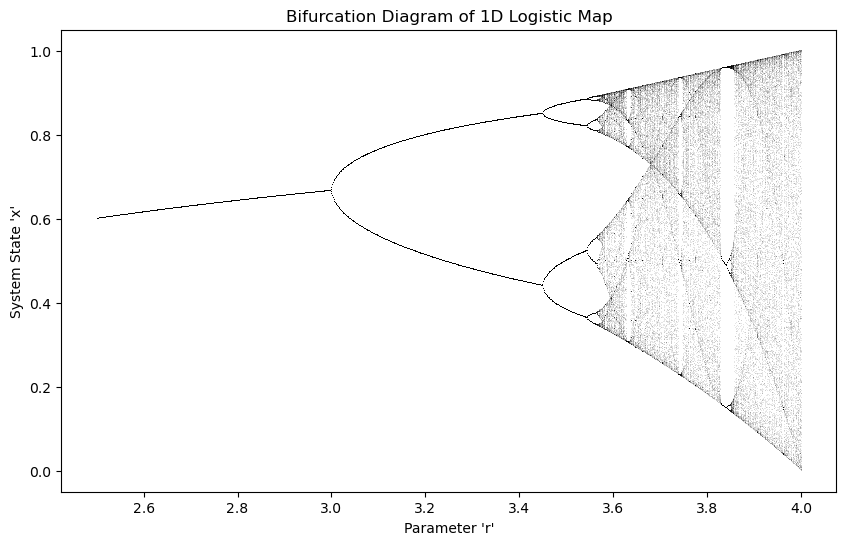

Calculating 1D Lyapunov Exponent...
LLE for 1D Logistic Map (r=4.0): 0.6931 (Ideal is ln(2) ~ 0.693)
----------------------------------------

--- 2. Analyzing 3D Coupled Map (mod 10) ---
Generating 3D Coupled Bifurcation Diagram...


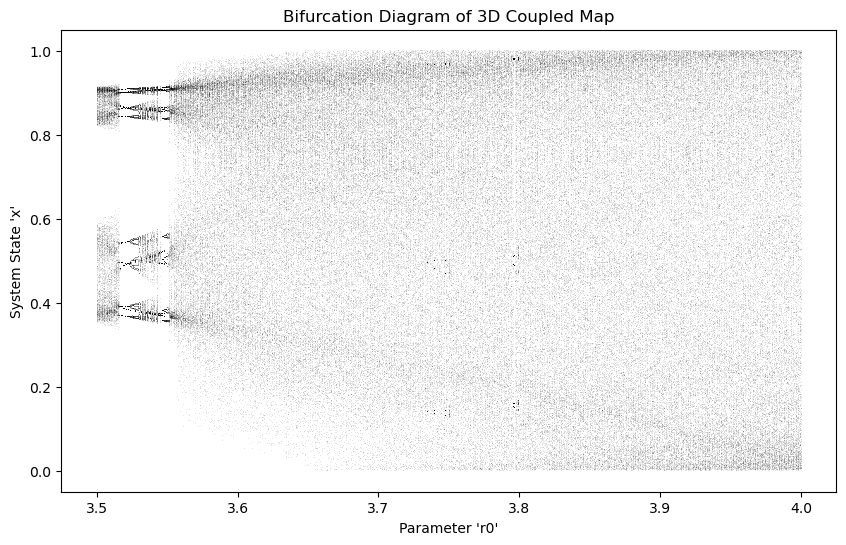

Calculating 3D Coupled Lyapunov Exponent...
LLE for 3D Coupled Map: 0.6814 (Positive indicates chaos)
----------------------------------------

--- 3. Analyzing FULL Dynamic Cascaded System ---
Generating Cascaded Bifurcation Diagram...


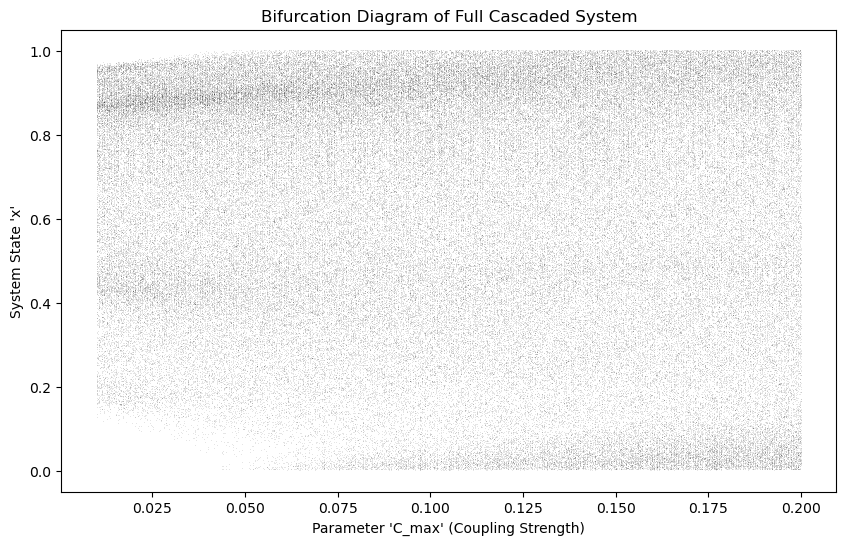

Calculating Cascaded Lyapunov Exponent...
LLE for Full Cascaded System: 0.6953 (Positive indicates chaos)
----------------------------------------



In [13]:
try:
    analyze_1D_logistic()
    analyze_3D_coupled()
    analyze_cascaded_system()

except Exception as e:
    print(f"An unexpected error occurred during analysis: {e}")
    traceback.print_exc()

--- Running Encryption/Decryption Test ---
Loaded 'Abu_Dhabi.jpg' and resized to (256, 256, 3)
Generating chaotic key sequence...
Generated key of size 196608
Encrypting image...
Decrypting image...


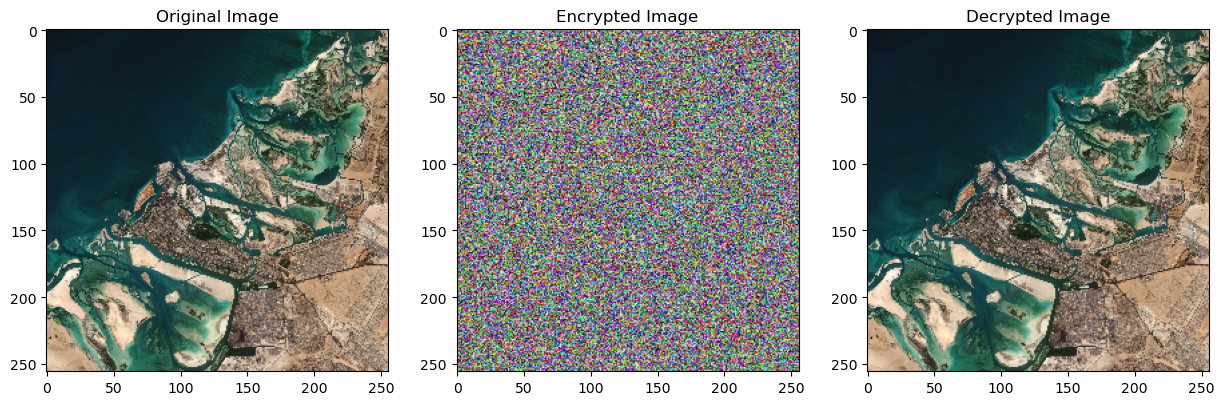

----------------------------------------



In [15]:
# ========================================
image_filename = "images/Abu_Dhabi.jpg"
# ========================================

try:
    print("--- Running Encryption/Decryption Test ---")
    original_img = load_and_preprocess(image_filename)
    print(f"Loaded '{image_filename}' and resized to {original_img.shape}")

    print("Generating chaotic key sequence...")
    chaotic_seq_8bit = get_chaotic_key_8bit(original_img.size) 
    print(f"Generated key of size {chaotic_seq_8bit.size}")

    print("Encrypting image...")
    encrypted_img = encrypt_image_mixed_cbc(original_img, chaotic_seq_8bit)
    cv2.imwrite("encrypted_image.png", encrypted_img)

    print("Decrypting image...")
    decrypted_img = decrypt_image_mixed_cbc(encrypted_img, chaotic_seq_8bit)
    cv2.imwrite("decrypted_image.png", decrypted_img)
    
    # --- Plot the main (a, b, c) results ---
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    # Convert BGR (OpenCV) to RGB (Matplotlib) for correct display
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    
    plt.subplot(1, 3, 2)
    plt.title("Encrypted Image")
    plt.imshow(encrypted_img)
    
    plt.subplot(1, 3, 3)
    plt.title("Decrypted Image")
    plt.imshow(cv2.cvtColor(decrypted_img, cv2.COLOR_BGR2RGB))
    
    plt.savefig("figure_3_main_result.png", dpi=300)
    plt.show()
    print("----------------------------------------\n")

except FileNotFoundError as e:
    print(f"ERROR: {e}")
    print(f"Please make sure '{image_filename}' is in the same folder.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    traceback.print_exc()

In [17]:
try:
    print("--- Calculating Security Metrics ---")

    # 1. Entropy
    entropy_orig = calculate_entropy(original_img)
    entropy_enc = calculate_entropy(encrypted_img)
    print(f"Information Entropy (Original): {entropy_orig:.4f}")
    print(f"Information Entropy (Encrypted): {entropy_enc:.4f} (Ideal is ~8)")

    # 2. Correlation
    h_orig, v_orig, d_orig = calculate_correlation(original_img)
    h_enc, v_enc, d_enc = calculate_correlation(encrypted_img)
    print(f"Correlation (Original H, V, D): {h_orig:.4f}, {v_orig:.4f}, {d_orig:.4f}")
    print(f"Correlation (Encrypted H, V, D): {h_enc:.4f}, {v_enc:.4f}, {d_enc:.4f} (Ideal is ~0)")

    # 3. NPCR & UACI (Differential Attack Test)
    print("Calculating NPCR & UACI (Differential Attack)...")
    original_img_modified = original_img.copy()
    
    # Change one *value* (the B value of the first pixel)
    current_pixel_value = int(original_img_modified[0, 0, 0])
    original_img_modified[0, 0, 0] = (current_pixel_value + 1) % 256
    
    # Encrypt the modified image with the *same key*
    encrypted_img_C2 = encrypt_image_mixed_cbc(original_img_modified, chaotic_seq_8bit)
    
    # Compare the two ciphertexts
    npcr = calculate_npcr(encrypted_img, encrypted_img_C2)
    uaci = calculate_uaci(encrypted_img, encrypted_img_C2)

    print(f"NPCR: {npcr:.2f}% (Ideal is > 99.6%)")
    print(f"UACI: {uaci:.2f}% (Ideal is ~ 33.4%)")
    print("----------------------------------------\n")
    
except Exception as e:
    print(f"An error occurred during metrics calculation: {e}")
    traceback.print_exc()

--- Calculating Security Metrics ---
Information Entropy (Original): 7.5490
Information Entropy (Encrypted): 7.9991 (Ideal is ~8)
Correlation (Original H, V, D): 0.8317, 0.8203, 0.7944
Correlation (Encrypted H, V, D): 0.0096, 0.0021, 0.0001 (Ideal is ~0)
Calculating NPCR & UACI (Differential Attack)...
NPCR: 100.00% (Ideal is > 99.6%)
UACI: 33.32% (Ideal is ~ 33.4%)
----------------------------------------



Generating Figure 5: Histograms...
Saved 'figure_5_histograms.png'


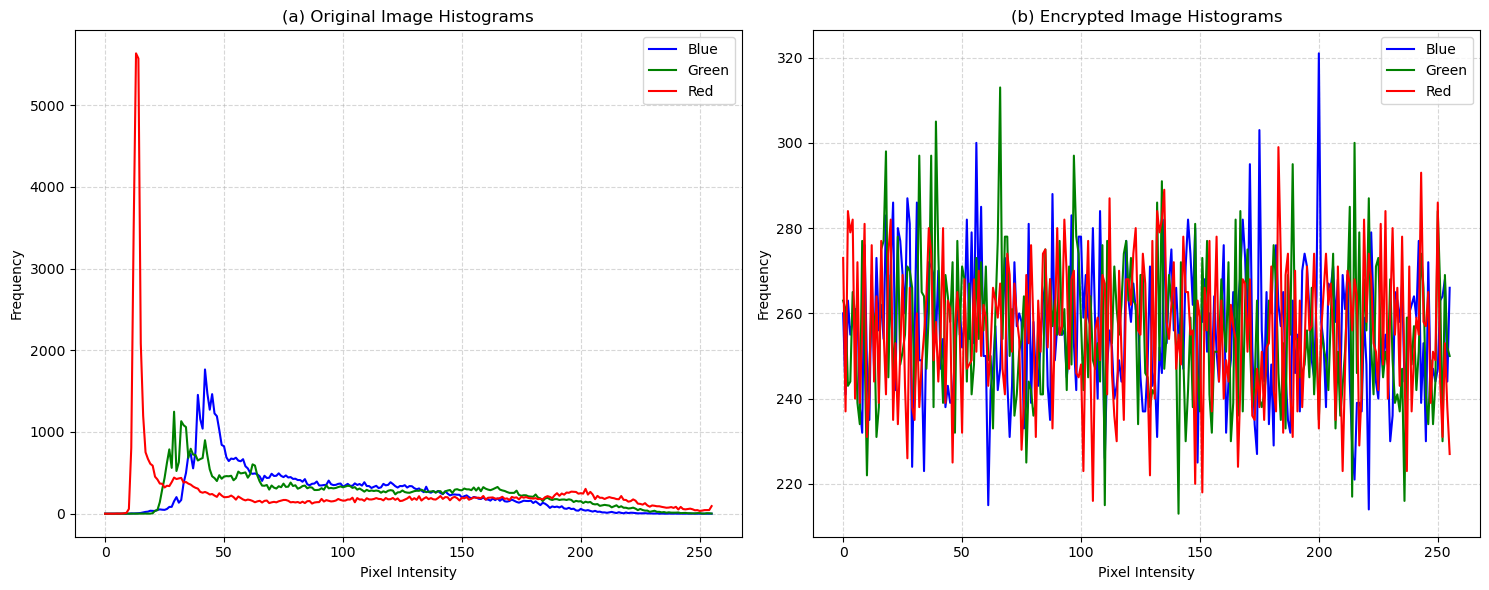

In [19]:
print("Generating Figure 5: Histograms...")

plt.figure(figsize=(15, 6))
colors = ('b', 'g', 'r') # OpenCV loads as BGR
channel_labels = ('Blue', 'Green', 'Red')

plt.subplot(1, 2, 1)
for i, (col, label) in enumerate(zip(colors, channel_labels)):
    hist = cv2.calcHist([original_img], [i], None, [256], [0, 256])
    plt.plot(hist, color=col, label=label)
plt.title('(a) Original Image Histograms')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(1, 2, 2)
for i, (col, label) in enumerate(zip(colors, channel_labels)):
    hist = cv2.calcHist([encrypted_img], [i], None, [256], [0, 256])
    plt.plot(hist, color=col, label=label)
plt.title('(b) Encrypted Image Histograms')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('figure_5_histograms.png', dpi=300)
print("Saved 'figure_5_histograms.png'")
plt.show()

Generating Figure 6: Correlation Scatter Plots...
Saved 'figure_6_correlation.png'


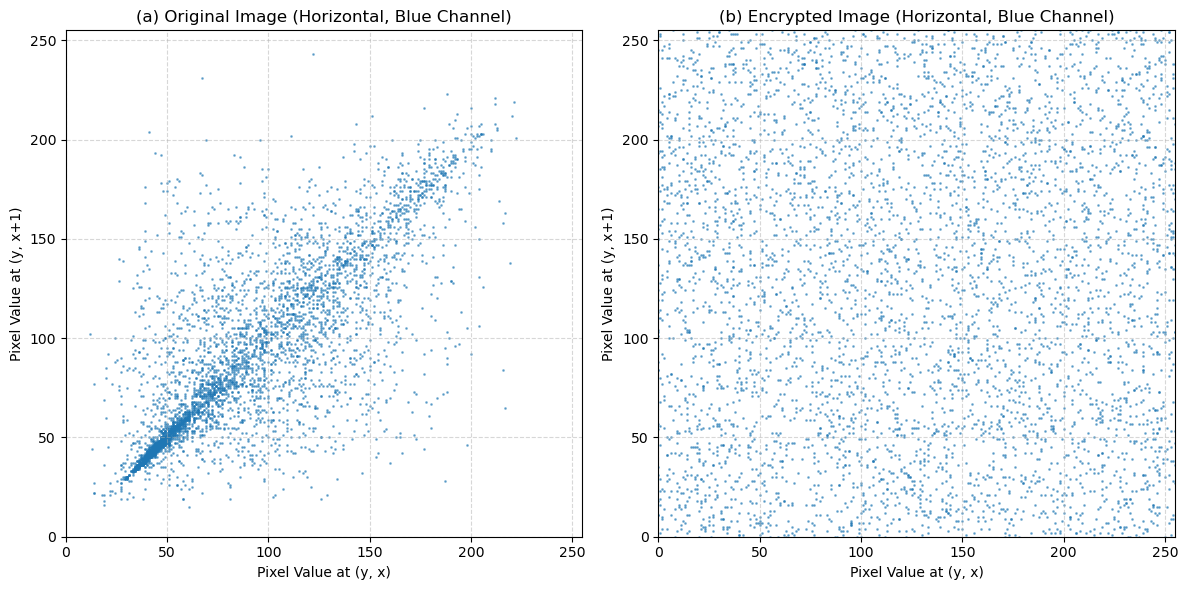

In [21]:
print("Generating Figure 6: Correlation Scatter Plots...")

# Select one channel (e.g., Blue channel, index 0)
channel_orig = original_img[:, :, 0]
channel_enc = encrypted_img[:, :, 0]

# Get pixel pairs for horizontal correlation
x_orig = channel_orig[:, :-1].flatten()
y_orig = channel_orig[:, 1:].flatten()
x_enc = channel_enc[:, :-1].flatten()
y_enc = channel_enc[:, 1:].flatten()

# To make the plot readable, we take a random sample
sample_size = 5000
if len(x_orig) > sample_size:
    indices = random.sample(range(len(x_orig)), sample_size)
    x_orig_sample = x_orig[indices]
    y_orig_sample = y_orig[indices]
    x_enc_sample = x_enc[indices]
    y_enc_sample = y_enc[indices]
else:
    x_orig_sample, y_orig_sample = x_orig, y_orig
    x_enc_sample, y_enc_sample = x_enc, y_enc

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(x_orig_sample, y_orig_sample, s=1, alpha=0.5)
plt.title('(a) Original Image (Horizontal, Blue Channel)')
plt.xlabel('Pixel Value at (y, x)')
plt.ylabel('Pixel Value at (y, x+1)')
plt.xlim(0, 255)
plt.ylim(0, 255)
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(1, 2, 2)
plt.scatter(x_enc_sample, y_enc_sample, s=1, alpha=0.5)
plt.title('(b) Encrypted Image (Horizontal, Blue Channel)')
plt.xlabel('Pixel Value at (y, x)')
plt.ylabel('Pixel Value at (y, x+1)')
plt.xlim(0, 255)
plt.ylim(0, 255)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('figure_6_correlation.png', dpi=300)
print("Saved 'figure_6_correlation.png'")
plt.show()